# Chapter 5, Example 2a nested
## 3-fold cross-validation on Iris dataset

In [1]:
import torch
from torch import nn

from sklearn import datasets
from sklearn.model_selection import KFold

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lr = 0.1
no_epochs = 1000

no_labels = 3
no_features = 4
hidden_units = [2, 4, 6, 8, 10, 12]

no_folds_inner = 3
no_folds_outer = 3

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
no_inputs = 4
no_outputs = 3

# input data
iris = datasets.load_iris()
iris.data -= np.mean(iris.data, axis=0)

no_data = len(iris.data)

X = iris.data

# convert the targets into one-hot matrix
Y = np.zeros((no_data, no_outputs))
for i in range(no_data):
    Y[i, iris.target[i]] = 1
    
print(np.shape(X))
print(np.shape(Y))

(150, 4)
(150, 3)


In [4]:
class FFN(nn.Module):
    def __init__(self, no_features, hidden_units, no_labels):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, no_labels),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits

In [5]:
cv_inner = KFold(n_splits=no_folds_inner, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=no_folds_inner, shuffle=True, random_state=2)

cv_acc = []
for train_idx, test_idx in cv_outer.split(X, Y):
    x_train, y_train  = X[train_idx], Y[train_idx]
    x_test, y_test = X[test_idx], Y[test_idx]
    
    fold_in = 0
    acc_ = []
    for train_idx_in, test_idx_in in cv_inner.split(x_train, y_train):
        x_train_in, y_train_in  = x_train[train_idx_in], y_train[train_idx_in]
        x_test_in, y_test_in = x_train[test_idx_in], y_train[test_idx_in]
        
        acc__ = []
        for no_hidden in hidden_units:
        
            model = FFN(no_inputs, no_hidden, no_outputs)
    
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
            for epoch in range(no_epochs):
                pred = model(torch.tensor(x_train_in, dtype=torch.float))
                loss = loss_fn(pred, torch.tensor(y_train_in, dtype=torch.float))
    
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
            pred = model(torch.tensor(x_test_in, dtype=torch.float))
            acc = (pred.argmax(1) == torch.tensor(y_test_in, dtype=torch.float).argmax(1)).type(torch.float).mean()
    
            acc__.append(acc.item())
    
        opt_hidden = hidden_units[np.argmax(acc__)]
    
        model = FFN(no_inputs, opt_hidden, no_outputs)
    
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
        for epoch in range(no_epochs):
            pred = model(torch.tensor(x_train, dtype=torch.float))
            loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        pred = model(torch.tensor(x_test, dtype=torch.float))
        acc = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float).argmax(1)).type(torch.float).mean()
    
    
        acc_.append(acc)
        print('fold %d test accuracy %g opt hidden %d'%(fold_in, acc_[fold_in], opt_hidden))
        fold_in += 1
    
    print('* mean accuracy = %g *'% np.mean(acc_))
    cv_acc.append(np.mean(acc_))
    
print('* mean cv accuracy = %g *'% np.mean(cv_acc))

fold 0 test accuracy 0.98 opt hidden 2
fold 1 test accuracy 0.98 opt hidden 6
fold 2 test accuracy 1 opt hidden 2
* mean accuracy = 0.986667 *
fold 0 test accuracy 0.98 opt hidden 2
fold 1 test accuracy 0.96 opt hidden 2
fold 2 test accuracy 0.98 opt hidden 2
* mean accuracy = 0.973333 *
fold 0 test accuracy 0.94 opt hidden 2
fold 1 test accuracy 0.94 opt hidden 4
fold 2 test accuracy 0.92 opt hidden 2
* mean accuracy = 0.933333 *
* mean accuracy = 0.964444 *


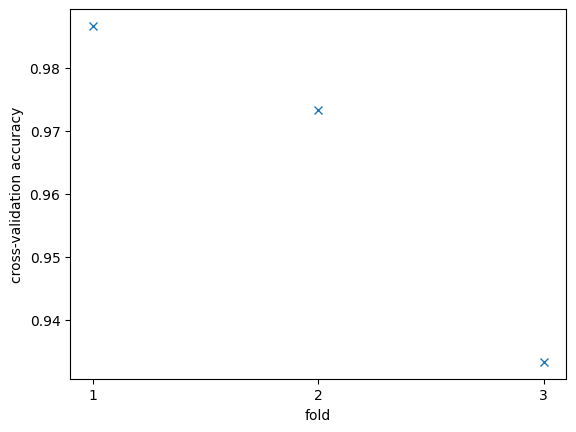

In [7]:
plt.figure(1)
plt.plot([1, 2, 3], cv_acc, marker = 'x', linestyle = 'None')
plt.xticks([1, 2, 3])
plt.xlabel('fold')
plt.ylabel('cross-validation accuracy')
plt.show()